Download and Setup

In [ ]:
!pip install torch torchvision

In [ ]:
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import os
import pandas as pd
import numpy as np

means = [0.485, 0.456, 0.406]
stds  = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    lambda x: x.convert('RGB'),
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd

class DDI_Dataset(Dataset):
    def __init__(self, root, csv_path=None, transform=None):
        self.root = root
        if csv_path is None:
            csv_path = os.path.join(os.path.dirname(root), "ddi_metadata.csv")

        self.annotations = pd.read_csv(csv_path)
        self.image_files = self.annotations['DDI_file'].tolist()
        self.transform = transform

        m_key = 'malignant'
        if m_key not in self.annotations:
            self.annotations[m_key] = self.annotations['malignancy(malig=1)'].apply(lambda x: x == 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        file_name = self.image_files[index]
        img_path = os.path.join(self.root, file_name)

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        annotation = self.annotations.iloc[index]
        target = int(annotation['malignant'])
        skin_tone = annotation['skin_tone']

        return img_path, img, target, skin_tone

    def subset(self, skin_tone=None, diagnosis=None):
        skin_tone = [12, 34, 56] if skin_tone is None else skin_tone
        diagnosis = ["benign", "malignant"] if diagnosis is None else diagnosis

        for si in skin_tone:
            assert si in [12, 34, 56], f"{si} is not a valid skin tone"
        for di in diagnosis:
            assert di in ["benign", "malignant"], f"{di} is not a valid diagnosis"

        # Filter the annotations based on skin tone and diagnosis
        filtered_annotations = self.annotations[
            (self.annotations['skin_tone'].isin(skin_tone)) &
            (self.annotations['malignant'].isin([di == "malignant" for di in diagnosis]))
        ]

        indices = filtered_annotations.index.tolist()

        return Subset(self, indices)


Image 1:
Path: /content/DDI/images/000001.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


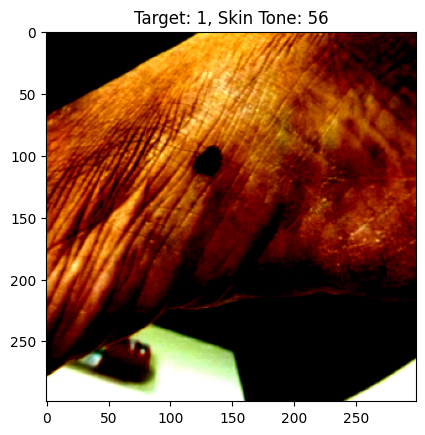

Image 2:
Path: /content/DDI/images/000002.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


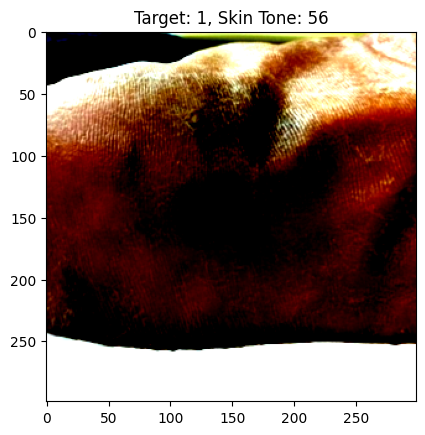

Image 3:
Path: /content/DDI/images/000003.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


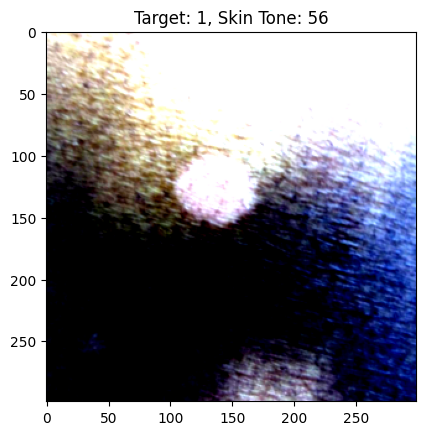

Image 4:
Path: /content/DDI/images/000004.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


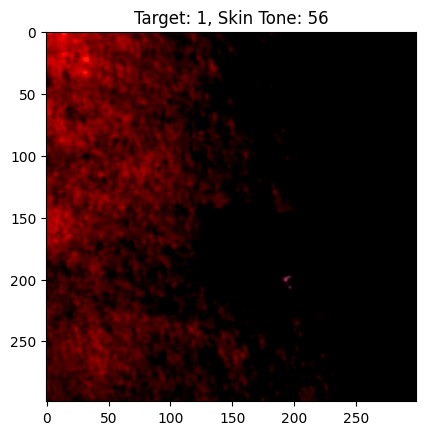

Image 5:
Path: /content/DDI/images/000005.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 12


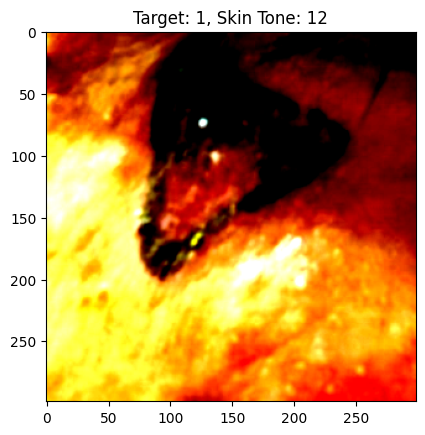

In [ ]:
import matplotlib.pyplot as plt

root = '/content/DDI/images'
dataset = DDI_Dataset(root=root, transform=test_transform)

for i in range(5):
    path, img, target, skin_tone = dataset[i]
    print(f"Image {i+1}:")
    print(f"Path: {path}")
    print(f"Target (Malignant: 1, Benign: 0): {target}")
    print(f"Skin Tone: {skin_tone}")

    plt.imshow(img.permute(1, 2, 0))  # Permute the tensor dimensions to (H, W, C) for plotting
    plt.title(f"Target: {target}, Skin Tone: {skin_tone}")
    plt.show()

In [ ]:
import shutil
import os

malignant_dir = '/content/DDI/images/malignant'
benign_dir = '/content/DDI/images/benign'

os.makedirs(malignant_dir, exist_ok=True)
os.makedirs(benign_dir, exist_ok=True)

for i in range(655):
    path, img, target, skin_tone = dataset[i]
    file_name = os.path.basename(path)
    if target == 1:
        dest_dir = malignant_dir
    else:
        dest_dir = benign_dir

    dest_path = os.path.join(dest_dir, file_name)
    shutil.move(path, dest_path)
    print(f"Moved {file_name} to {dest_dir}")

print("Image sorting complete.")

Moved 000001.png to /content/DDI/images/malignant
Moved 000002.png to /content/DDI/images/malignant
Moved 000003.png to /content/DDI/images/malignant
Moved 000004.png to /content/DDI/images/malignant
Moved 000005.png to /content/DDI/images/malignant
Moved 000006.png to /content/DDI/images/malignant
Moved 000007.png to /content/DDI/images/malignant
Moved 000008.png to /content/DDI/images/malignant
Moved 000009.png to /content/DDI/images/malignant
Moved 000010.png to /content/DDI/images/malignant
Moved 000011.png to /content/DDI/images/malignant
Moved 000012.png to /content/DDI/images/malignant
Moved 000013.png to /content/DDI/images/malignant
Moved 000014.png to /content/DDI/images/malignant
Moved 000015.png to /content/DDI/images/malignant
Moved 000016.png to /content/DDI/images/malignant
Moved 000017.png to /content/DDI/images/malignant
Moved 000018.png to /content/DDI/images/malignant
Moved 000019.png to /content/DDI/images/malignant
Moved 000020.png to /content/DDI/images/malignant


Model

In [ ]:
!pip install coremltools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

# Define normalization parameters
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Create paths for benign and malignant images
        for label, sub_dir in enumerate(['benign', 'malignant']):
            sub_dir_path = os.path.join(root_dir, sub_dir)
            for filename in os.listdir(sub_dir_path):
                if filename.lower().endswith('.png'):  # Ensure it's a .png file
                    self.image_paths.append(os.path.join(sub_dir_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Load dataset and create dataloader
root = '/content/DDI/images'
dataset = CustomDataset(root_dir=root, transform=test_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(AttentionLayer, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        value = self.value_conv(x).view(batch_size, -1, width * height)

        attention = torch.bmm(query, key)  # Attention score
        attention = nn.functional.softmax(attention, dim=-1)

        out = torch.bmm(value, attention.permute(0, 2, 1))  # Weighted sum of values
        out = out.view(batch_size, C, width, height)
        return out + x  # Residual connection

# Model with Attention
class ResNetWithAttention(nn.Module):
    def __init__(self):
        super(ResNetWithAttention, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.attention = AttentionLayer(in_channels=self.base_model.fc.in_features)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)  # Binary classification

    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.attention(x)  # Apply attention

        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

# Initialize model
model = ResNetWithAttention().to(device)
model.train()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
def train_model(dataloader, model, criterion, optimizer, epochs=13):
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

train_model(dataloader, model, criterion, optimizer)

# Save the trained model
torch.save(model.state_dict(), 'resnet_attention_model.pth')

# Feature extraction function
def extract_features(dataloader, model):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feature = model.base_model(imgs)  # Get features from ResNet
            features.append(feature.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and split data
features, labels = extract_features(dataloader, model)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Scale features and train logistic regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000, solver='liblinear', C=1.0)
clf.fit(X_train, y_train)

# Predict and evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch 1, Loss: 0.5699
Epoch 2, Loss: 0.2221
Epoch 3, Loss: 0.0593
Epoch 4, Loss: 0.0140
Epoch 5, Loss: 0.0078
Epoch 6, Loss: 0.0043
Epoch 7, Loss: 0.0028
Epoch 8, Loss: 0.0016
Epoch 9, Loss: 0.0008
Epoch 10, Loss: 0.0004
Epoch 11, Loss: 0.0003
Epoch 12, Loss: 0.0005
Epoch 13, Loss: 0.0009
Accuracy: 0.99237


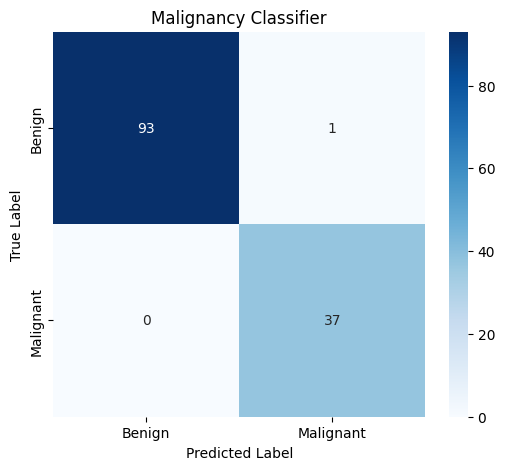

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Benign', 'Malignant']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Malignancy Classifier')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

False Positive Rate: 0.0106
False Negative Rate: 0.0000
Sensitivity: 1.0000
Specificity: 0.9894


In [ ]:
import os
from PIL import Image
from torchvision import transforms as T
import torch
import numpy as np
import torch.nn.functional as F

# Define normalization parameters (same as used during training)
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

# Function to load a single image and preprocess it
def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Function to predict logits and probabilities
def predict_image(image_path, model):
    model.eval()  # Set model to evaluation mode
    image = load_image(image_path, test_transform).to(device)

    with torch.no_grad():
        logits = model(image)
        probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities

    return logits.cpu().numpy(), probabilities.cpu().numpy()

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # Adjust final layer for binary classification
model.load_state_dict(torch.load('resnet101_model.pth'))
model = model.to(device)

# Test with your own image
image_path = '/content/DDI/images/malignant/000025.png'  # Replace with your image path
logits, probabilities = predict_image(image_path, model)

# Print results
print(f"Logits: {logits}")
print(f"Probabilities: {probabilities}")
print(f"Predicted Class: {np.argmax(probabilities)}")

In [ ]:
traceable_model = torch.jit.trace(model, load_image(image_path, test_transform).to(device))

# Define the input type for Core ML conversion
_input = ct.ImageType(
    name="input_1",
    shape=(1, 3, 299, 299),  # Shape should match the input tensor (batch, channels, height, width)
    bias=[-m/s for m, s in zip(means, stds)],  # Bias correction (mean/std)
    scale=1.0/(255.0 * stds[0])  # Scale correction (1/(255 * std))
)

# Convert to Core ML
mlmodel = ct.convert(
    traceable_model,
    inputs=[_input]
)

mlmodel.user_defined_metadata['description'] = "Skin lesion classification model (ResNet18)"
mlmodel.user_defined_metadata['version'] = "1.0"
mlmodel.short_description = "Classifies skin lesions as benign or malignant."

# Save the model
mlmodel.save("RiskClassifier.mlpackage")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Move the model to Google Drive
!mv RiskClassifier.mlpackage/ /content/drive/My\ Drive/